## Build a simple CTA trend-following system in Python - week of June 19

In [1]:
import pandas as pd
import numpy as np
import pandas.io.data as web
import datetime as dt
import statsmodels.api as sm

//anaconda/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [10]:
######################################### Take longer series ETFs
tickers = ['SPY','LTNC','BAC','MUNMF','TDEY','COWI','VXX','GDX'
           ,'USMJ','EEM','BSSP','BMIX','BIEL','SIML','GE','MJMJ','IFCR','XLF','NGBL','AAPL']

start = dt.datetime(2015,1,1)
end = dt.datetime.today() #(2016,1,12)
#########################################

def get_Prices(ticker_list, st, ed, this_price):
# function that gives back "Adj Close" for list of tickers with common start, end dates
    dfm = pd.DataFrame([])
    for idx, tick in enumerate(ticker_list):
        price = web.DataReader(tick,'yahoo',st,ed)
        tmp = price[this_price]
        dfm[tick] = tmp
    return dfm

df = get_Prices(tickers,start,end,'Adj Close').dropna() # drop any pesky "NaN"s
#df    = get_Prices(tickers,start,end,'Open').dropna() # drop any pesky "NaN"s
#df    = get_Prices(tickers,start,end,'Close').dropna() # drop any pesky "NaN"s

print df.shape #, df_Open.shape, df_Close.shape
print df.tail()

IOError: after 3 tries, Yahoo! did not return a 200 for url 'http://ichart.finance.yahoo.com/table.csv?s=BSSP&a=0&b=1&c=2015&d=6&e=18&f=2016&g=d&ignore=.csv'

In [11]:
# Build indicator, simple indicators are moving avg cross over
# indicator determines -- when to buy? when to sell? 
%pylab inline
import matplotlib.pyplot as plt

#fast_ewma = pd.ewma(df_AdjClose, span=5)
#slow_ewma = pd.ewma(df_AdjClose, span=20)

#Short moving average as 30 days, lomg moving average as 200 days.
fast_ma = pd.rolling_mean(df, 30)
slow_ma = pd.rolling_mean(df, 200)

MACD = fast_ma - slow_ma

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


NameError: name 'df' is not defined

In [18]:
print fast_ma.tail()
print slow_ma.tail()
print MACD.tail()

                   SPY         GLD     OIL
Date                                      
2016-06-13  207.693410  119.002501  6.4795
2016-06-14  207.756084  119.051000  6.4785
2016-06-15  207.900333  119.124000  6.4645
2016-06-16  208.072438  119.238000  6.4455
2016-06-17  208.241260  119.442000  6.4420
                   SPY       GLD     OIL
Date                                    
2016-06-13  200.353009  117.5375  5.4843
2016-06-14  200.574934  117.7103  5.5021
2016-06-15  200.756068  117.8971  5.5156
2016-06-16  200.971874  118.0601  5.5300
2016-06-17  201.154623  118.2267  5.5464
                 SPY     GLD     OIL
Date                                
2016-06-13  7.340401  1.4650  0.9952
2016-06-14  7.181150  1.3407  0.9764
2016-06-15  7.144265  1.2269  0.9489
2016-06-16  7.100564  1.1779  0.9155
2016-06-17  7.086637  1.2153  0.8956


In [19]:
# Create signal
signal_dummy = 1.0*(MACD>0)
signal_dummy[signal_dummy==0] = -1
print signal_dummy.describe()

#print signal_dummy


               SPY          GLD          OIL
count  1122.000000  1122.000000  1122.000000
mean      0.509804    -0.376114    -0.288770
std       0.860674     0.926987     0.957825
min      -1.000000    -1.000000    -1.000000
25%       1.000000    -1.000000    -1.000000
50%       1.000000    -1.000000    -1.000000
75%       1.000000     1.000000     1.000000
max       1.000000     1.000000     1.000000


(-1.25, 1.25)

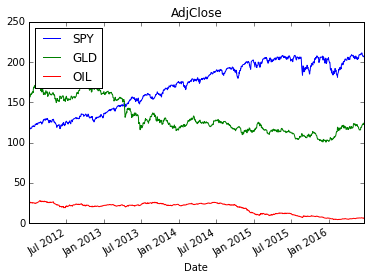

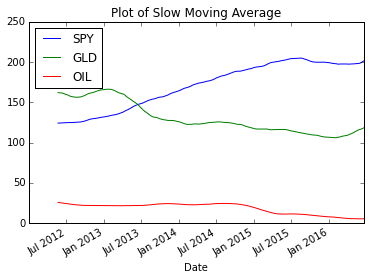

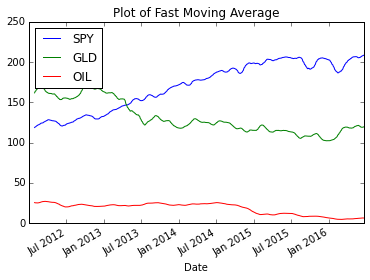

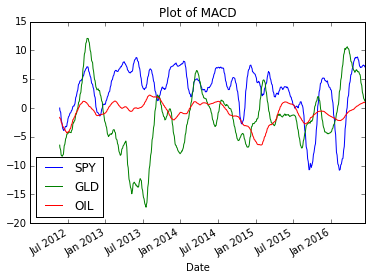

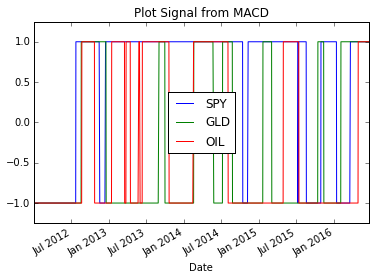

In [20]:
# Plots
df.plot()
title('AdjClose')

slow_ma.plot()
title('Plot of Slow Moving Average')

fast_ma.plot()
title('Plot of Fast Moving Average')

MACD.plot()
title('Plot of MACD')

signal_dummy.plot()
title('Plot Signal from MACD')
plt.ylim([-1.25,1.25])

                  SPY        GLD       OIL
Date                                      
2016-06-13 -42.010641 -27.169973  2.809996
2016-06-14 -41.393853 -28.469976  2.579996
2016-06-15 -42.165841 -26.899976  2.929996
2016-06-16 -42.165841 -26.899976  2.929996
2016-06-17 -42.165841 -26.899976  2.929996


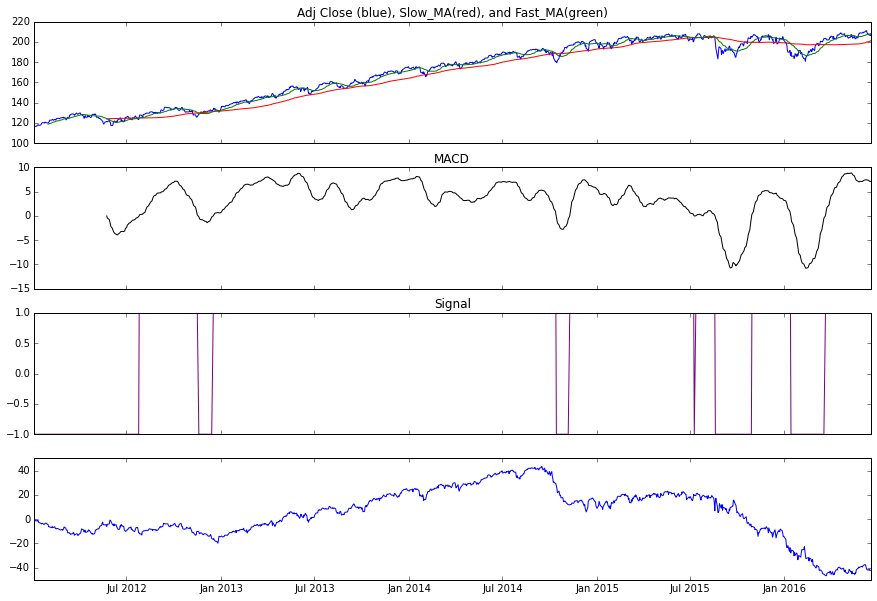

In [21]:
# Plot SPY
import matplotlib.pyplot as plt

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15,10)) #sharey=True, 

ax1.plot(df.index, df['SPY'])
ax1.set_title('Adj Close (blue), Slow_MA(red), and Fast_MA(green)')
ax1.plot(df.index, slow_ma['SPY'],'r')
ax1.plot(df.index, fast_ma['SPY'],'g')

ax2.plot(df.index,MACD['SPY'], 'black') 
ax2.set_title('MACD')

ax3.plot(df.index,signal_dummy['SPY'],'purple')
#ax3.axis([-0.1 1.1])
ax3.set_title('Signal')

# Use signal_dummy and compute returns for given strategy, examine cumulative PnL
# if signal > 0, buy, else sell if signal <=0

chg_df = df.shift(-2) - df.shift(-1) # mutliply signal by 2 period forward returns ("no cheat")
pnl = chg_df.fillna(0) * signal_dummy.fillna(0)
port_pnl = pnl.sum(axis=1)

cpnl_port = port_pnl.cumsum()

cpnl = pnl.cumsum()
#cpnl.plot(figsize=(15,10))
#cpnl.tail()
ax4.plot(df.index, cpnl['SPY'])

print cpnl.tail()

            SPY  GLD  OIL
Date                     
2012-01-03    0    0    0
2012-01-04    0    0    0
2012-01-05    0    0    0
2012-01-06    0    0    0
2012-01-09    0    0    0


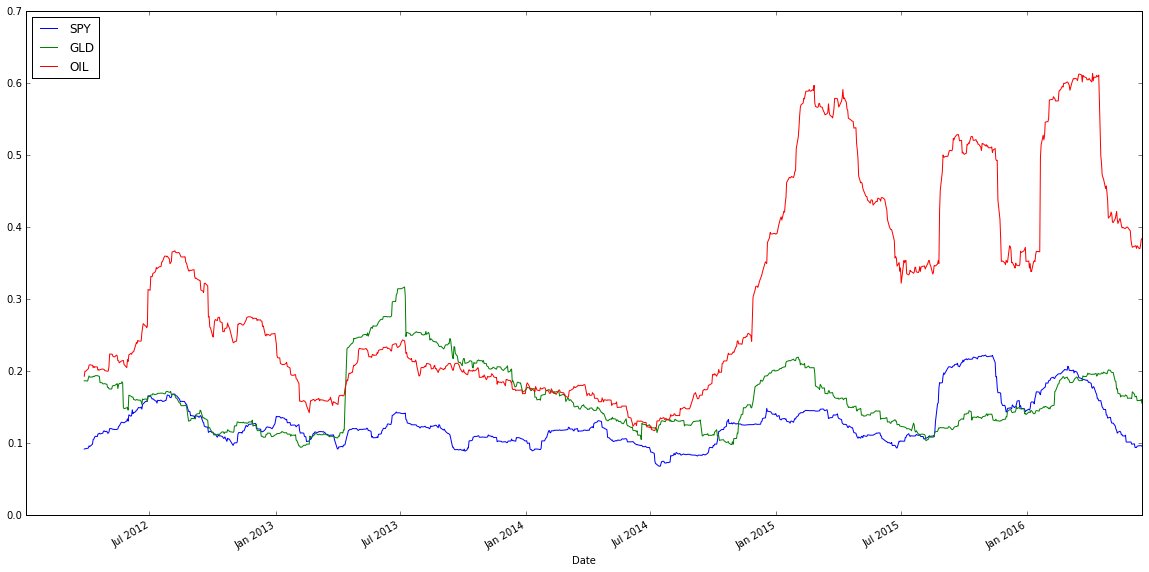

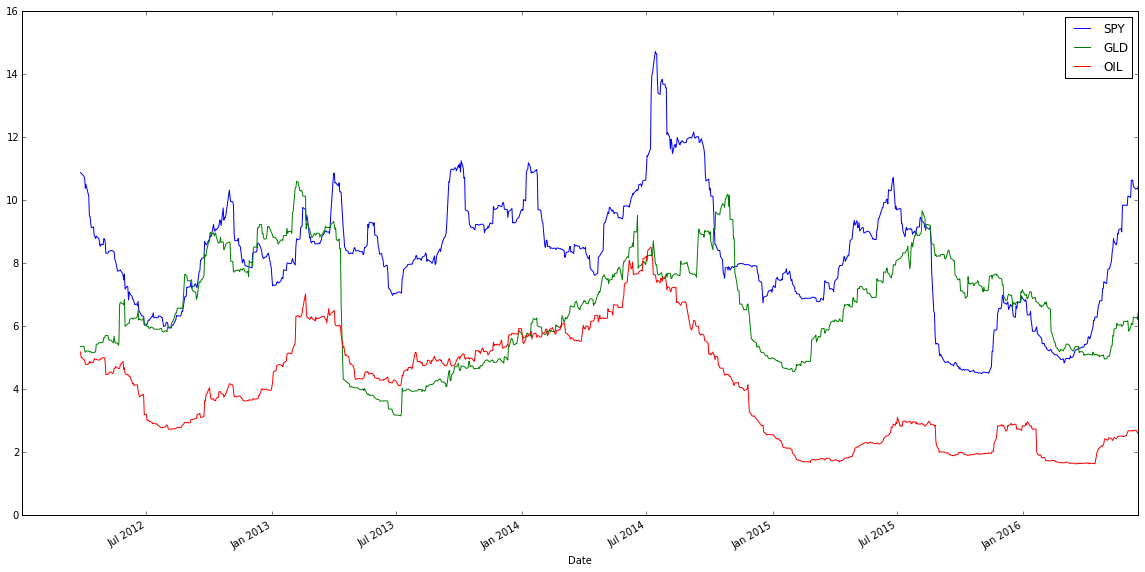

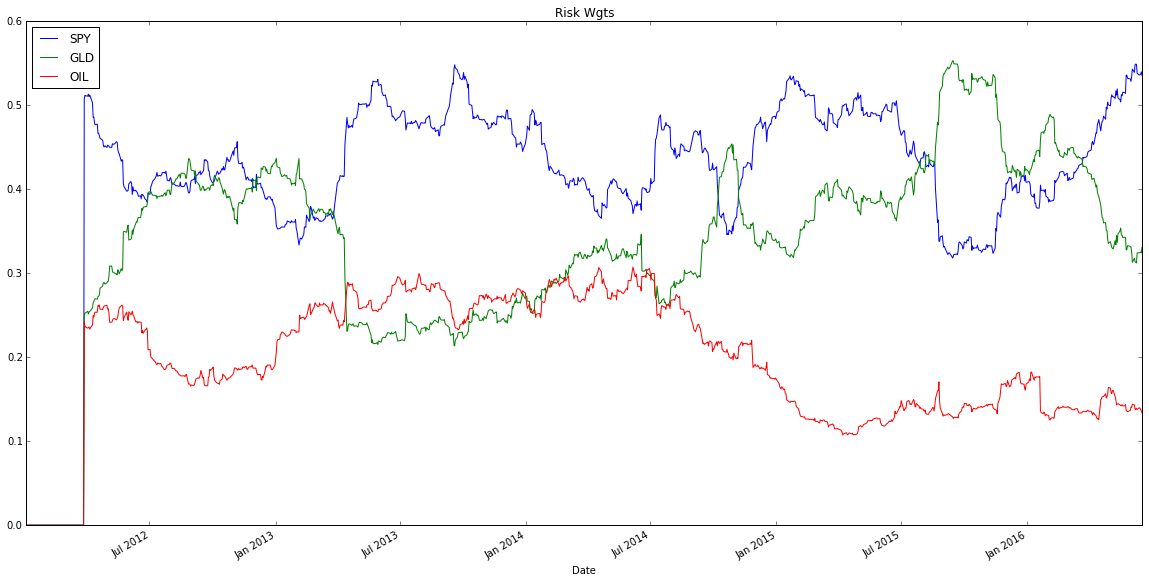

In [22]:
# create position size using -- "inverse power function"

# compute rolling std for each series
rets = df.pct_change(1)
rets = rets.fillna(0)

roll_std = pd.rolling_std(rets, 60)*sqrt(252)

roll_std.plot(figsize=(20,10))
inv_roll_std = 1/roll_std
inv_roll_std.plot(figsize=(20,10))

den_ = inv_roll_std.sum(axis=1)
tickers = roll_std.columns
#print tickers

risk_wgts = pd.DataFrame([]);
for ticker in tickers:
    risk_wgts[ticker]=inv_roll_std[ticker]/den_;
    
risk_wgts = risk_wgts.fillna(0)

print risk_wgts.head()
risk_wgts.plot(figsize=(20,10)); title('Risk Wgts')


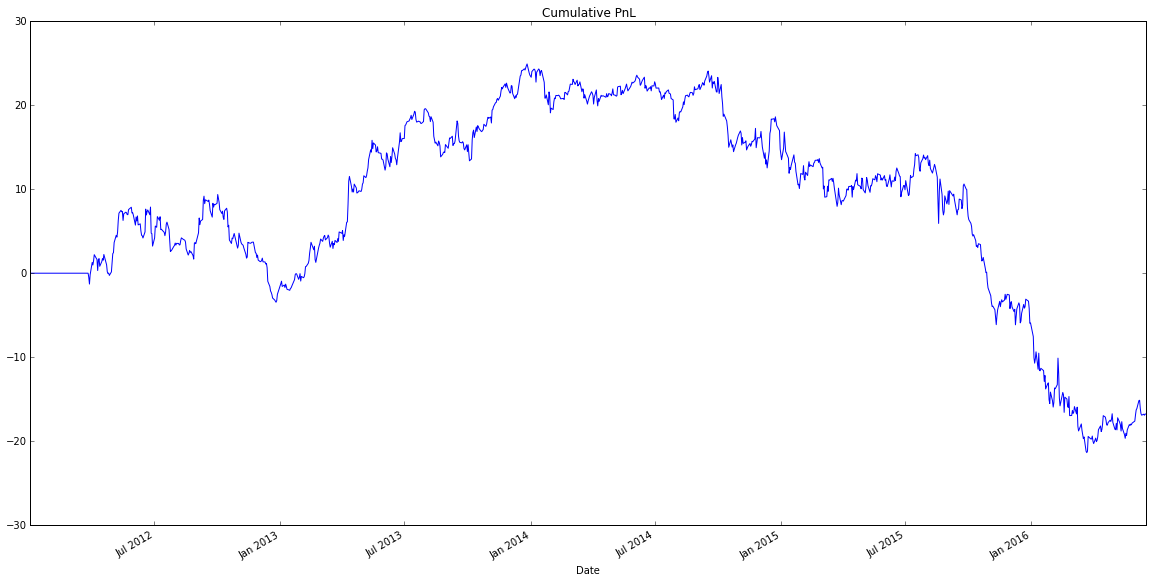

In [24]:
################################
# Need to change code here for HWK#3 but remember to "no cheat"
risk_wgt_pnl = pnl *  risk_wgts
################################
risk_wgt_pnl.sum(axis=1).cumsum().plot(figsize=(20,10)); title('Cumulative PnL')


In [4]:
# http://www.quantinsti.com/blog/python-trading/